In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True)

### merge M14 with LAMOST DR6

In [3]:
dlam = pd.read_csv("/Users/k_masuda/Dropbox/astrodata/lamost/dr6_kplr.csv", delimiter="|")
dlam = dlam.rename({"# kepid": "kepid"}, axis='columns')

In [4]:
dm14 = pd.read_csv("data/mcquillan+14.tsv", delimiter="|", comment="#")
dm14["kepid"] = dm14.KIC
print (len(dm14), "stars in MqQuillan catalog.")

34030 stars in MqQuillan catalog.


In [5]:
plotdir = 'mcquillan_sample_plots/'

### check RV difference

In [6]:
drot = pd.merge(dm14, dlam, on='kepid', how='left')
print (len(drot), "stars in M14-LAMOST DR6 including duplications.")
print (len(drot.drop_duplicates("kepid", keep='first')), "stars in M14-LAMOST DR6 without duplications.")

37685 stars in M14-LAMOST DR6 including duplications.
34030 stars in M14-LAMOST DR6 without duplications.


In [7]:
rvmin = drot.groupby("kepid", as_index=False).min()[["kepid", "rv"]].rename({"rv": "rvmin"}, axis='columns')
rvmax = drot.groupby("kepid", as_index=False).max()[["kepid", "rv"]].rename({"rv": "rvmax"}, axis='columns')

In [8]:
teffstd = drot.groupby("kepid", as_index=False).std()[["kepid", "teff"]]
print ("mean of Teff SD (K):", np.mean(teffstd[teffstd.teff==teffstd.teff].teff))

mean of Teff SD (K): 34.39811866116855


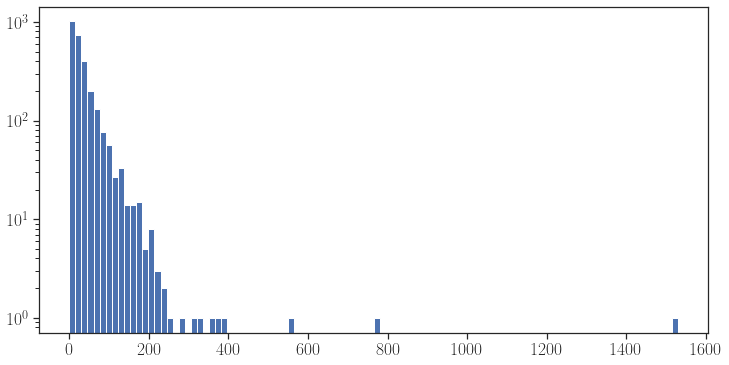

In [9]:
plt.yscale("log")
plt.hist(teffstd[teffstd.teff==teffstd.teff].teff, bins=100);

In [10]:
len(rvmin)

34030

In [11]:
dupids = np.array(drot.kepid[drot.duplicated("kepid", keep='first')])
drv = pd.merge(rvmin, rvmax, on='kepid')
drv['dup'] = drv.kepid.isin(dupids)
drv['rvdiff'] = drv['rvmax'] - drv['rvmin']

SD of RV difference (km/s): 10.061661591729097


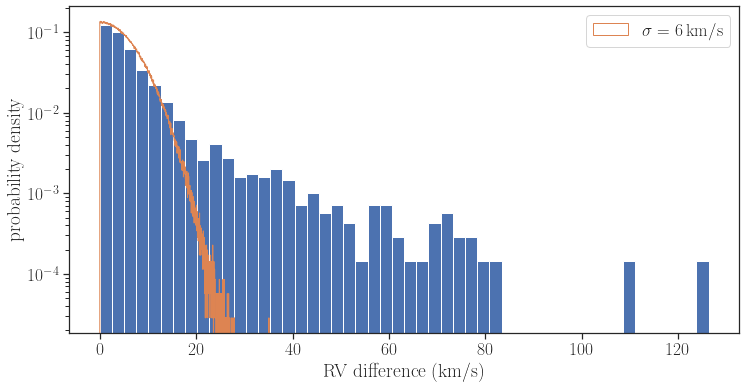

In [12]:
rnds = np.random.randn(int(1e6))*6
print ("SD of RV difference (km/s):", np.std(drv.rvdiff[drv.dup]))
plt.xlabel("RV difference (km/s)")
plt.ylabel("probability density")
plt.yscale("log")
plt.hist(drv.rvdiff[drv.dup], bins=50, density=True)
plt.hist(np.abs(rnds), density=True, bins=1000, histtype='step', label='$\sigma=6\,\mathrm{km/s}$')
plt.legend()
plt.savefig(plotdir+"rvdiff.png", dpi=200, bbox_inches="tight")

In [13]:
print (len(dlam.groupby('kepid', as_index=False).mean()), "Kepler stars in LAMOST DR6.")

61280 Kepler stars in LAMOST DR6.


In [14]:
drot = pd.merge(dm14, dlam.groupby('kepid', as_index=False).mean().reset_index(drop=True), on='kepid')
drot = pd.merge(drot, drv, on='kepid')
print (len(drot), "stars in the sample.")

8772 stars in the sample.


### xmatch with Gaia, remove photometric binaries and evolved stars

In [15]:
dgaia = pd.read_csv("data/kepler_gaiaedr3_cds.csv")
dgaia['kepid'] = dgaia.KIC
dkic = pd.read_csv("/Users/k_masuda/Dropbox/research_notes/data/kepler_stellar_17.csv", comment='#', delimiter="|")
dgaia = pd.merge(dgaia, dkic[['kepid', 'kepmag']], on='kepid')

In [16]:
print (len(dgaia), "Gaia matches within 5 arcsec.")

267750 Gaia matches within 5 arcsec.


In [17]:
d = pd.merge(drot, dgaia, how='left', on='kepid')
d['darcsec'] = d.angDist
d['GminK'] = d.phot_g_mean_mag - d.kepmag
d['mg'] = d.phot_g_mean_mag + 5 * np.log10(d.parallax) - 10

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
print (len(d), 'sources.')
print (np.sum(d.duplicated("kepid")), 'duplications.')

12215 sources.
3443 duplications.


In [19]:
def check_multis(d):
    plt.xlabel("distance (arcsec)")
    plt.ylabel("$G-K_p$")
    plt.xscale("log")
    plt.plot(d.darcsec, d.GminK, '.')
    kepids = list(d.kepid[d.kepid.duplicated(keep="first")])
    for _kepid in kepids:
        _idx = d.kepid==_kepid
        plt.plot(d.darcsec[_idx], d.GminK[_idx], 'o-', mfc="none", color="C1", lw=0.)

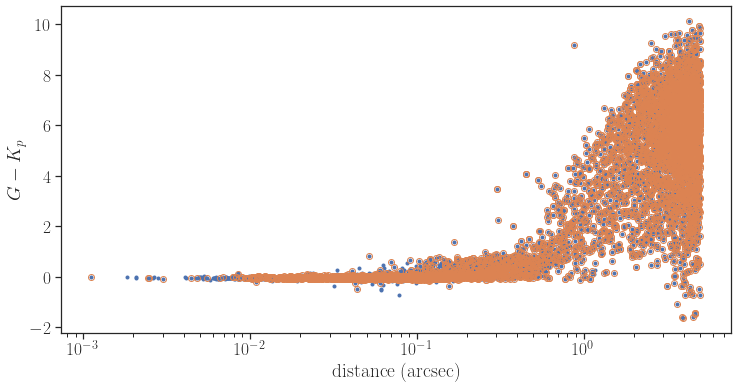

In [20]:
check_multis(d)

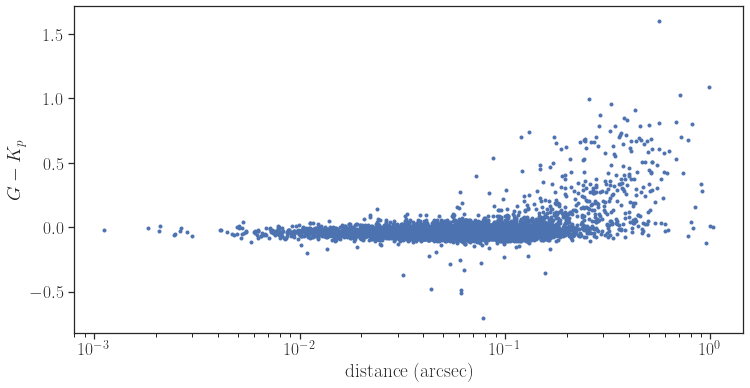

In [21]:
d1 = d.sort_values("darcsec", ascending=True).drop_duplicates("kepid", keep="first").reset_index(drop=True)
d1 = d1[d1.parallax_over_error>10].reset_index(drop=True)
check_multis(d1)

In [22]:
print (len(d1), "sources with Gaia info.")
print ("mean and standard dev of G minus K:", np.mean(d1.GminK), np.std(d1.GminK))
print ("mean and 99% distance:", np.mean(d1.darcsec), np.percentile(d1.darcsec, 99))

8309 sources with Gaia info.
mean and standard dev of G minus K: -0.022788136719219938 0.08739525627877252
mean and 99% distance: 0.08331857612227725 0.4173485600000001


In [23]:
def iterative_fit(x, y, order, nsigma=[1.,3.], maxniter=10):
    A = np.vander(x, order+1)
    idx = np.ones_like(x) > 0
    for i in range(maxniter):
        w = np.linalg.solve(np.dot(A[idx].T, A[idx]), np.dot(A[idx].T, y[idx]))
        mu = np.dot(A, w)
        res = y - mu
        sigma = np.sqrt(np.median(res**2))
        idx_new = (res > -nsigma[0]*sigma) & (res < nsigma[1]*sigma)
        if np.sum(idx)==np.sum(idx_new):
            idx = idx_new
            break
        idx = idx_new
    return mu, w

In [24]:
idx = (d1.teff>4000) & (d1.teff<6500) & (d1.mg>0)
x, y = np.array((d1.teff[idx]-5500)/500), np.array(d1.mg[idx])
t0 = np.linspace(4000, 6500, 100)
x0 = (t0 - 5500) / 500.

In [25]:
order = 5
mu, w = iterative_fit(x, y, order)
msfunc = lambda teff: np.dot(np.vander((teff - 5500) / 500., order+1), w)

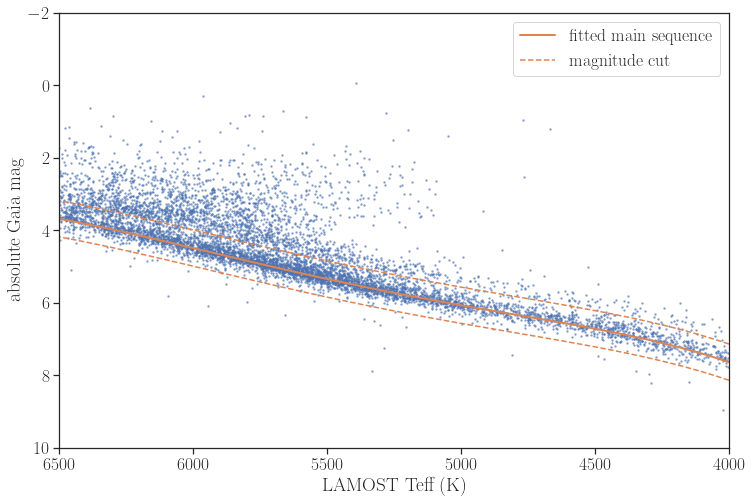

In [26]:
plt.figure(figsize=(12,8))
plt.xlabel("LAMOST Teff (K)")
plt.ylabel("absolute Gaia mag")
plt.xlim(6500, 4000)
plt.ylim(10, -2)
plt.plot(d1.teff, d1.mg, '.', markersize=3, alpha=0.5)
#plt.plot(t0, func((t0-5500)/500.), '-')
plt.plot(t0, msfunc(t0), '-', color='C1', lw=2, label='fitted main sequence')
plt.plot(t0, msfunc(t0)-0.5, '--', color='C1', label='magnitude cut')
plt.plot(t0, msfunc(t0)+0.5, '--', color='C1')
plt.legend(loc='best')
plt.savefig(plotdir+"mg_teff_all.png", dpi=200, bbox_inches="tight")

In [27]:
idxrv = d1.rvdiff > 20
idxmg = np.abs(d1.mg - msfunc(d1.teff)) > 0.5
idxt = (d1.teff>4000) & (d1.teff<6500)
idx = ((~idxrv) & (~idxmg)) & idxt 
#idx &= (d1.ruwe<1.4)

In [28]:
print ("after M_G and teff cut:", np.sum(~idxmg&idxt))
print ("after M_G and teff and RV cut:", np.sum((~idxmg)&idxt&(~idxrv)))

after M_G and teff cut: 5022
after M_G and teff and RV cut: 4977


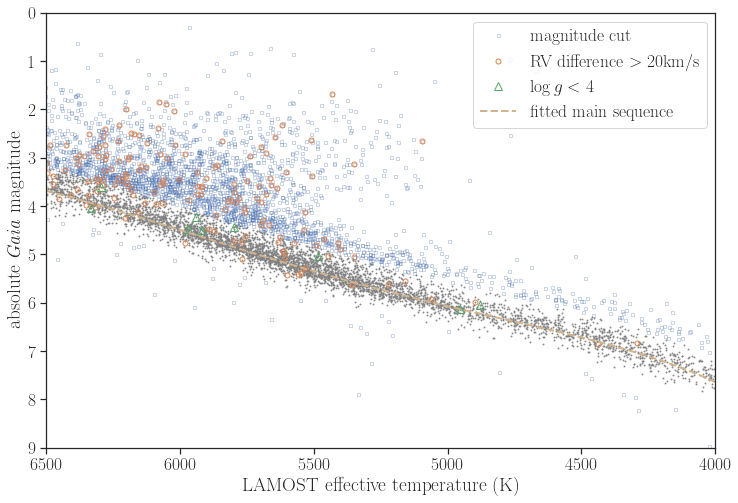

In [29]:
plt.figure(figsize=(12,8))
plt.xlabel("LAMOST effective temperature (K)")
plt.ylabel(r"absolute \textit{Gaia} magnitude")
plt.xlim(6500, 4000)
plt.ylim(10-1, -2+2)
plt.plot(d1.teff[idx], d1.mg[idx], '.', markersize=2, alpha=0.8, color='gray')
#plt.plot(d1.teff[idxmg], d1.mg[idxmg], 's', alpha=0.2, color='C2', markersize=3, label='magnitude cut')
plt.plot(d1.teff[idxmg], d1.mg[idxmg], 's', mfc='none', markersize=3, lw=0.1, alpha=0.3, label='magnitude cut')
plt.plot(d1.teff[idxrv], d1.mg[idxrv], 'o', mfc='none', markersize=5, lw=0.5, label='RV difference $> 20$km/s')
idxg = d1.logg < 4.
plt.plot(d1.teff[idx&idxg], d1.mg[idx&idxg], '^', mfc='none', markersize=8, lw=0.5, label='$\log g < 4$')
#plt.plot(d1.teff[idxmg], d1.mg[idxmg], 's', alpha=0.2, color='C2', markersize=3, label='magnitude cut'
plt.plot(t0, msfunc(t0), ls='dashed', color='tan', lw=2, label='fitted main sequence')
plt.legend(loc='upper right')
plt.savefig(plotdir+"mg_teff_cut.png", dpi=200, bbox_inches="tight")

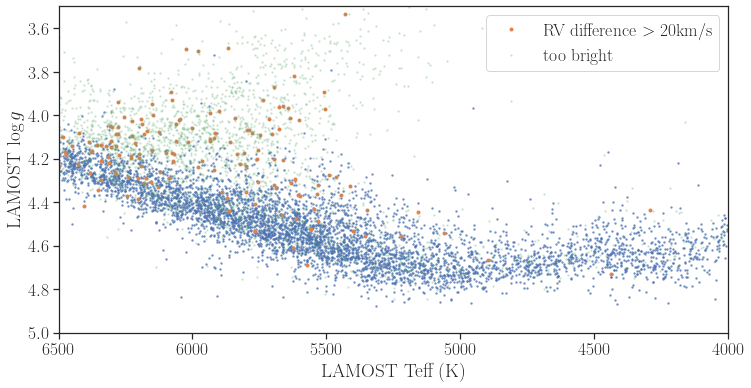

In [30]:
plt.xlabel("LAMOST Teff (K)")
plt.ylabel("LAMOST $\log g$")
plt.xlim(6500, 4000)
plt.ylim(5, 3.5)
plt.plot(d1.teff[idx], d1.logg[idx], '.', markersize=3, alpha=0.6)
plt.plot(d1.teff[idxrv], d1.logg[idxrv], '.', label='RV difference $> 20$km/s')
plt.plot(d1.teff[idxmg], d1.logg[idxmg], '.', alpha=0.2, color='C2', markersize=3, label='too bright')
plt.legend(loc='best')
#plt.plot(t0, logg0)
plt.savefig(plotdir+"logg_teff_cut.png", dpi=200, bbox_inches="tight")

In [31]:
len(d1[idx&(d1.logg>4)])

4968

### assign Kepler precision and Rossby number

In [32]:
from scipy.interpolate import interp1d
dprec = pd.read_csv("data/kepler_precision.txt", delim_whitespace=True)
kepsigma = interp1d(dprec.kepmag, dprec.long, kind='cubic')

# Jenkins et al. (2010)
def sigma_jenkins(kp):
    c = 3.46 * 10**(0.4*(12.-kp)+8.)
    return np.sqrt(c+7e7)/c * 1e6 # upper
    #return np.sqrt(c+7e6*np.fmax(1.,kp/14.)**4) / c * 1e6 # lower

In [33]:
def tau_g98(teff):
    return 314.24 * np.exp(-(teff/1952.5)-(teff/6250.)**18) + 0.002

#def tau_w11(teff):
#    mass = teff_to_mass(teff)
#    logm = np.log10(mass)
#    logtau = 1.16 - 1.49 * logm - 0.54 * logm * logm
#    return 10**logtau

In [34]:
d1['kepler_sigma'] = kepsigma(d1.kepmag)
d1['kepler_sigma_j'] = sigma_jenkins(d1.kepmag)
d1['tau'] = tau_g98(d1.teff)
d1['Rnorm'] = d1.Rper / d1.kepler_sigma
d1['Pnorm'] = d1.Prot / d1.tau

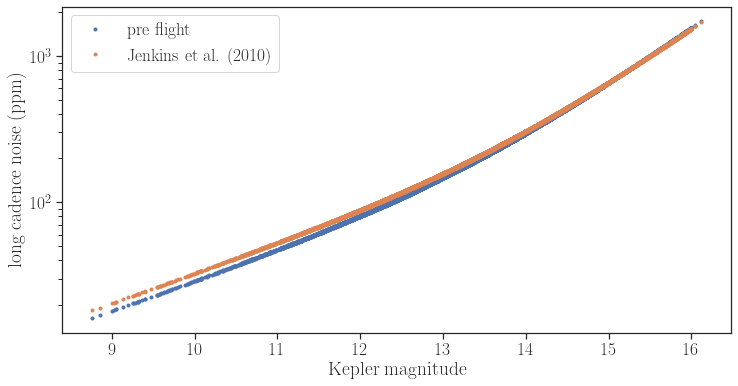

In [35]:
plt.yscale("log")
plt.plot(d1.kepmag, d1.kepler_sigma, '.', label='pre flight')
plt.plot(d1.kepmag, d1.kepler_sigma_j*1.5, '.', label='Jenkins et al. (2010)')
plt.ylabel("long cadence noise (ppm)")
plt.xlabel("Kepler magnitude")
plt.legend(loc='best');

### plots

In [36]:
rnlabel = "variability amplitude $R_\mathrm{per}$\n normalized by Kepler photometric precision"
rlabel = "variability amplitude $R_\mathrm{per}$ (ppm)"
pnlabel = r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$"
dtlabel = 'empirical detection threshold'
tefflabel = 'LAMOST $T_\mathrm{eff}$ (K)'
protlabel = 'rotation period $P_\mathrm{rot}$ (days)'
col = 'gray'

In [37]:
dclean = d1[idx&(d1.logg>4.)].reset_index(drop=True)
print (len(dclean), "stars in the final sample.")

4968 stars in the final sample.


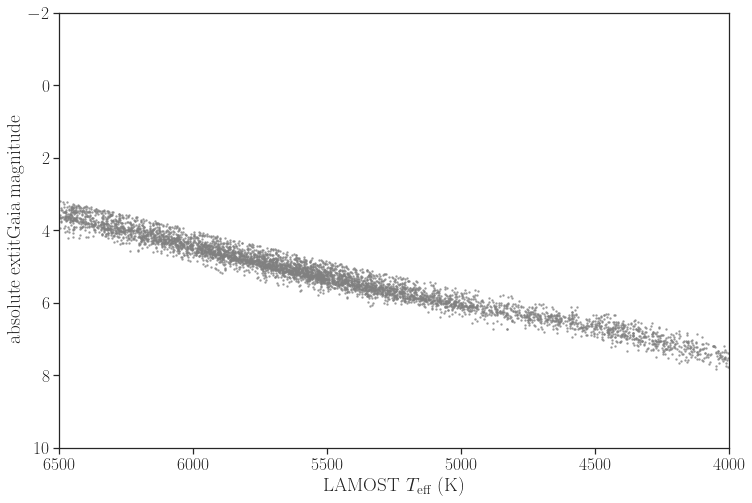

In [38]:
plt.figure(figsize=(12,8))
plt.xlabel(tefflabel)
plt.ylabel("absolute \textit{Gaia} magnitude")
plt.xlim(6500, 4000)
plt.ylim(10, -2)
plt.plot(dclean.teff, dclean.mg, '.', markersize=3, alpha=0.6, color=col)
#plt.plot(dclean.teff[idxg], dclean.mg[idxg], '.', markersize=10, alpha=0.6, label='$\log g<4$')
#plt.legend(loc='best')
plt.savefig(plotdir+"mg_teff_cut.png", dpi=200, bbox_inches="tight")

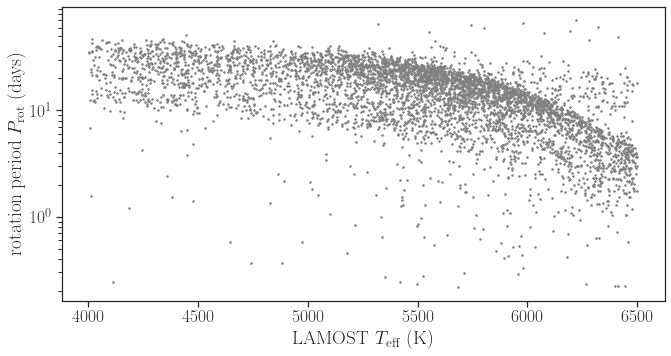

In [39]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(tefflabel)
plt.ylabel(protlabel)
plt.yscale("log")
plt.plot(dclean.teff, dclean.Prot, '.', markersize=3, color=col)
plt.savefig(plotdir+"prot_teff.png", dpi=200, bbox_inches="tight")

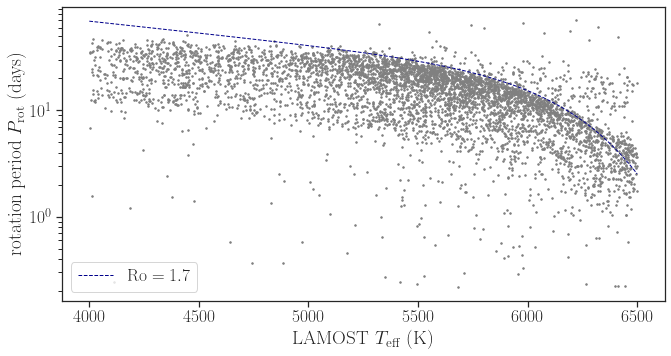

In [40]:
plt.figure(figsize=(12*0.9,6*0.9))
t0 = np.linspace(4000, 6500, 100)
plt.xlabel(tefflabel)
plt.ylabel(protlabel)
plt.yscale("log")
plt.plot(dclean.teff, dclean.Prot, '.', markersize=3, color=col)
#plt.plot(t0, tau_g98(t0)*1.7, ls='solid', color='darkblue', lw=4, alpha=0.4, label='$\mathrm{Ro}=1.7$')
plt.plot(t0, tau_g98(t0)*1.7, ls='dashed', color='darkblue', lw=1, label='$\mathrm{Ro}=1.7$')
plt.legend(loc='lower left')
plt.savefig(plotdir+"prot_teff_rocut.png", dpi=200, bbox_inches="tight")

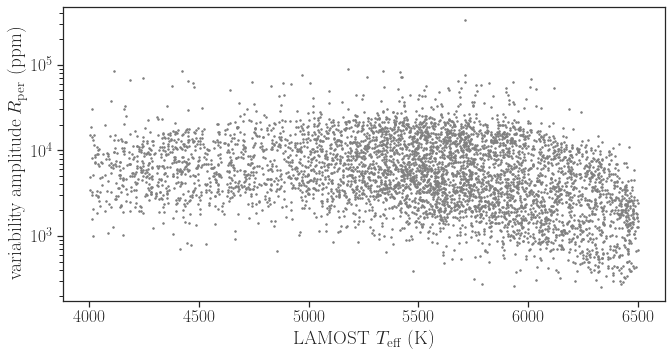

In [41]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(tefflabel)
plt.ylabel(rlabel)
plt.yscale("log")
plt.plot(dclean.teff, dclean.Rper, '.', markersize=3, color=col)
plt.savefig(plotdir+"rper_teff.png", dpi=200, bbox_inches="tight");

In [42]:
dm = pd.merge(dm14, dkic[['kepid', 'kepmag']], on='kepid')
dm['kepmag'][dm.kepmag<7] = 7
dm['kepsigma'] = kepsigma(dm.kepmag)

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


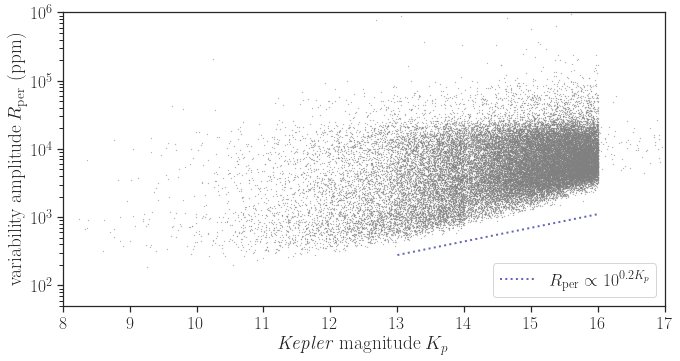

In [43]:
plt.figure(figsize=(12*0.9,6*0.9))
k0 = np.linspace(13, 16, 100)
plt.xlabel(r"\textit{Kepler} magnitude $K_p$")
plt.ylabel(rlabel)
plt.xlim(8, 17)
plt.ylim(5e1, 1e6)
#plt.xscale("log")
plt.yscale("log")
#plt.plot(dclean.kepmag, dclean.Rper, '.', markersize=3, color=col)
plt.plot(dm.kepmag, dm.Rper, '.', markersize=0.5, color=col)
plt.plot(k0, 0.7*10**(0.2*k0), color='darkblue', lw=2, ls='dotted', alpha=0.6, 
         label="$R_\mathrm{per}\propto 10^{0.2K_p}$")
plt.legend(loc='lower right')
plt.savefig("rper_kepmag.png", dpi=200, bbox_inches="tight")

In [44]:
R_th = 3.
R1 = np.percentile(dclean.Rnorm, 2)
print (R1)

3.144024274770147


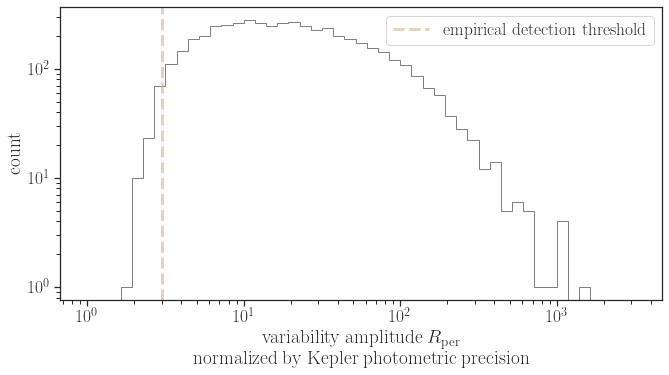

In [45]:
plt.figure(figsize=(12*0.9,6*0.9))
bins = np.logspace(0, 3.5, 50)
plt.xlabel(rnlabel)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("count")
plt.axvline(x=R_th, label=dtlabel, color='tan', lw=3, ls='dashed', alpha=0.6,)
plt.hist(dclean.Rnorm, bins=bins, histtype='step', lw=1, color=col)
plt.legend(loc='best')
plt.savefig(plotdir+"rper_hist.png", dpi=200, bbox_inches="tight")

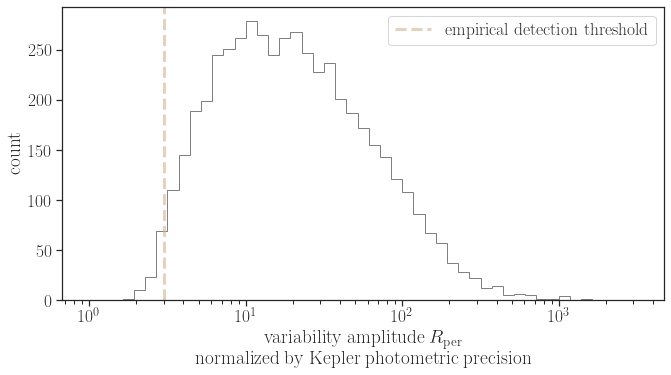

In [46]:
plt.figure(figsize=(12*0.9,6*0.9))
R1 = np.percentile(dclean.Rnorm, 2)
bins = np.logspace(0, 3.5, 50)
plt.xlabel(rnlabel)
#plt.yscale("log")
plt.xscale("log")
plt.ylabel("count")
plt.axvline(x=R_th, label=dtlabel, color='tan', lw=3, ls='dashed', alpha=0.6,)
plt.hist(dclean.Rnorm, bins=bins, histtype='step', lw=1, color=col)
plt.legend(loc='best')
plt.savefig(plotdir+"rper_hist_lin.png", dpi=200, bbox_inches="tight")

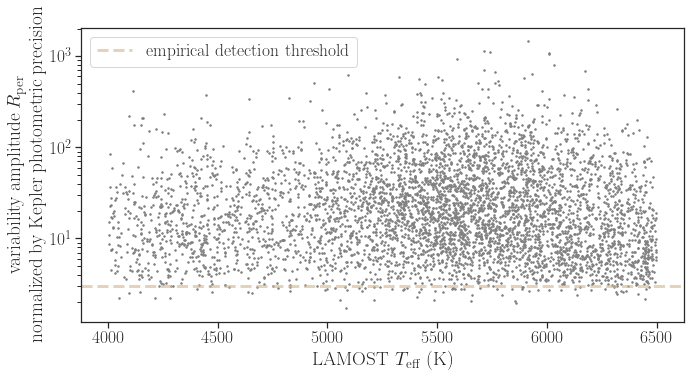

In [47]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(tefflabel)
plt.ylabel(rnlabel)
plt.yscale("log")
plt.plot(dclean.teff, dclean.Rnorm, '.', markersize=3, color=col)
plt.axhline(y=R_th, color='tan', lw=3, ls='dashed', alpha=0.6, label=dtlabel)
plt.legend(loc='best')
plt.savefig(plotdir+"rnorm_teff.png", dpi=200, bbox_inches="tight")

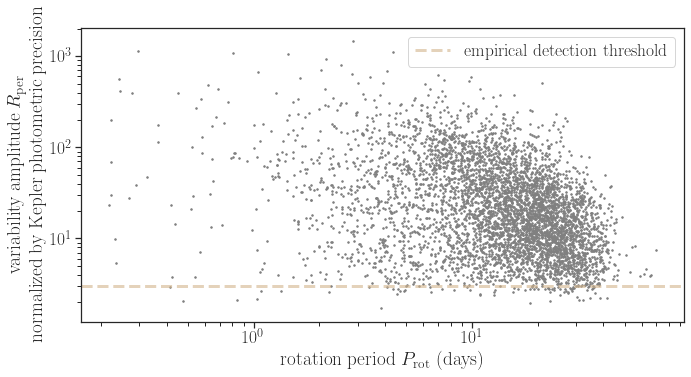

In [48]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(protlabel)
plt.ylabel(rnlabel)
plt.xscale("log")
plt.yscale("log")
plt.plot(dclean.Prot, dclean.Rnorm, '.', markersize=3, color=col)
plt.axhline(y=R_th, color='tan', lw=3, ls='dashed', alpha=0.6, label=dtlabel)
plt.legend(loc='best')
plt.savefig(plotdir+"rnorm_prot.png", dpi=200, bbox_inches="tight")

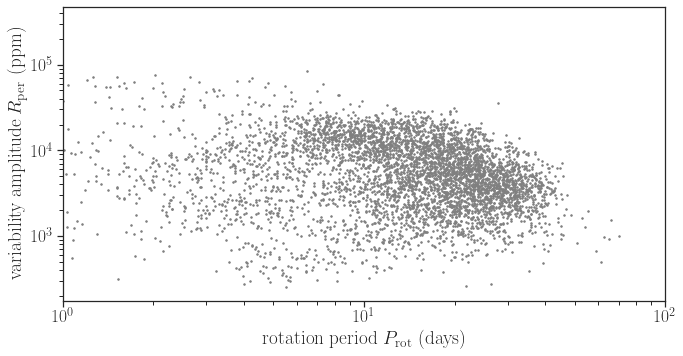

In [49]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlim(1, 100)
plt.xlabel(protlabel)
plt.ylabel(rlabel)
plt.yscale("log")
plt.xscale("log")
plt.plot(dclean.Prot, dclean.Rper, '.', markersize=3, color=col)
plt.savefig(plotdir+"rper_prot.png", dpi=200, bbox_inches="tight")

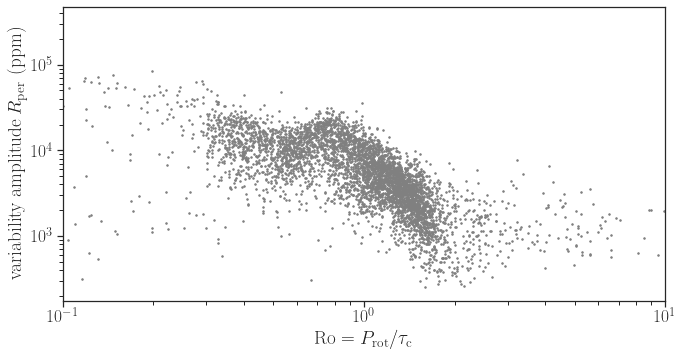

In [50]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(pnlabel)
plt.ylabel(rlabel)
plt.yscale("log")
plt.xscale("log")
plt.xlim(0.1, 10)
plt.plot(dclean.Pnorm, dclean.Rper, '.', markersize=3, color=col)
plt.savefig(plotdir+"rper_ro.png", dpi=200, bbox_inches="tight")

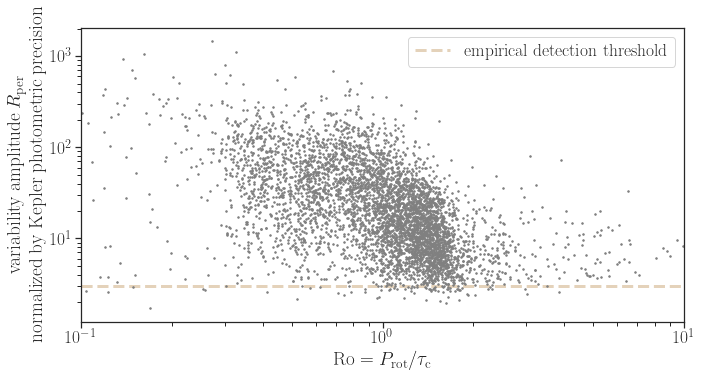

In [51]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(pnlabel)
plt.ylabel(rnlabel)
plt.yscale("log")
plt.xscale("log")
plt.xlim(0.1, 10)
plt.axhline(y=R_th, color='tan', lw=3, ls='dashed', alpha=0.6, label=dtlabel)
plt.plot(dclean.Pnorm, dclean.Rnorm, '.', markersize=3, color=col)
plt.legend(loc='best')
plt.savefig(plotdir+"rnorm_ro.png", dpi=200, bbox_inches="tight")

In [52]:
d1.to_csv("sample_all.csv", index=False)
dclean.to_csv("sample_clean.csv", index=False)

## Misc

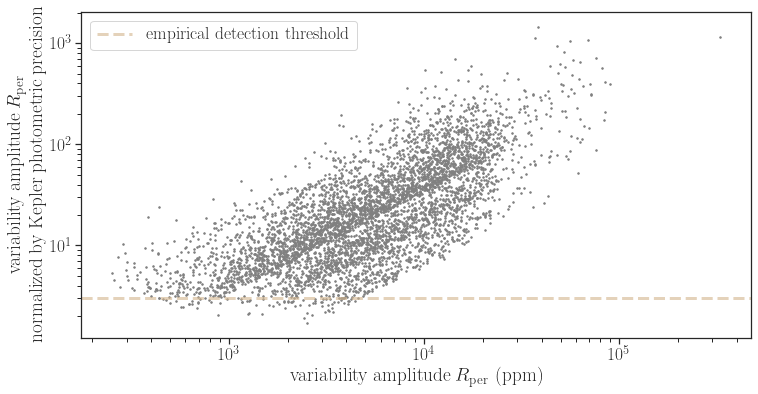

In [88]:
plt.xlabel(rlabel)
plt.ylabel(rnlabel)
plt.xscale("log")
plt.yscale("log")
plt.plot(dclean.Rper, dclean.Rnorm, '.', markersize=3, color=col)
plt.axhline(y=R_th, color='tan', lw=3, ls='dashed', alpha=0.6, label=dtlabel)
plt.legend(loc='best')

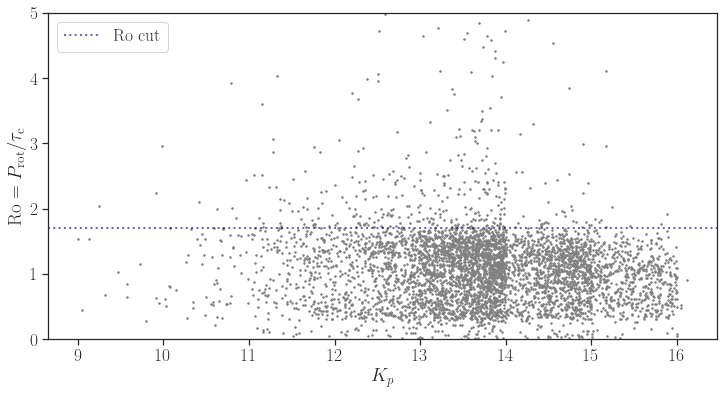

In [92]:
plt.xlabel("$K_p$")
plt.ylabel(pnlabel)
#plt.xscale("log")
#plt.yscale("log")
plt.ylim(0, 5)
plt.plot(dclean.kepmag, dclean.Pnorm, '.', markersize=3, color=col)
plt.axhline(y=1.7, color='darkblue', lw=2, ls='dotted', alpha=0.6, label="Ro cut")
plt.legend(loc='best')

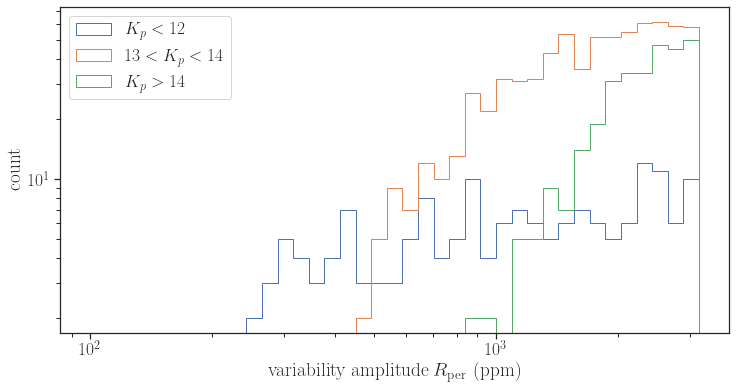

In [99]:
bins = np.logspace(2, 3.5, 40)
plt.xlabel(rlabel)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("count")
plt.hist(dclean.Rper[dclean.kepmag<12], bins=bins, histtype='step', lw=1, color='C0', label="$K_p<12$")
plt.hist(dclean.Rper[(dclean.kepmag>13)&(dclean.kepmag<14)], bins=bins, histtype='step', lw=1, color='C1', label="$13<K_p<14$")
plt.hist(dclean.Rper[dclean.kepmag>14], bins=bins, histtype='step', lw=1, color='C2', label="$K_p>14$")
plt.legend(loc='upper left')

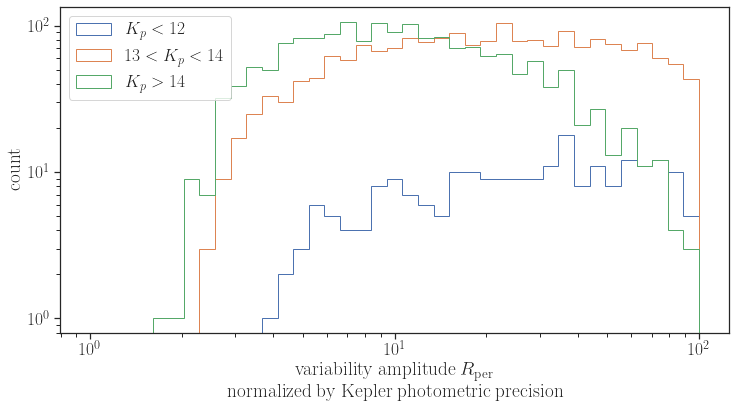

In [101]:
bins = np.logspace(0, 2, 40)
plt.xlabel(rnlabel)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("count")
plt.hist(dclean.Rnorm[dclean.kepmag<12], bins=bins, histtype='step', lw=1, color='C0', label="$K_p<12$")
plt.hist(dclean.Rnorm[(dclean.kepmag>13)&(dclean.kepmag<14)], bins=bins, histtype='step', lw=1, color='C1', label="$13<K_p<14$")
plt.hist(dclean.Rnorm[dclean.kepmag>14], bins=bins, histtype='step', lw=1, color='C2', label="$K_p>14$")
plt.legend(loc='upper left')